In [19]:
from funktionen import *

In [16]:
get_text("Q232")
#Text zur Tafelstube

Wikibase link: [https://computational-publishing-service.wikibase.cloud/entity/Q232](https://computational-publishing-service.wikibase.cloud/entity/Q232)

Kurator: Seeger, Ulrike









Beschreibung
------------



 Östlich an den Rittersaal schließt ein großer, 1837 unterteilter Raum an, bei dem es sich um die einstige Tafelstube handelt.\[1] Als Eckraum mit vier Doppelfenstern zur Gartenseite und weiteren drei Doppelfenstern zur Grabenseite erhielt die Tafelstube viel Licht. Auch konnte der Fürst von dort aus auf die Stadt und den Lustgarten blicken, der in der Renaissance dem Schloss südöstlich vorgelagert war.\[2] Gemessen an der Größe des Raumes war die Tafelstube nicht sehr hoch. Die Decke mit kräftigen Unterzügen ruhte ursprünglich auf vier Stützen, deren Position einem Plan des 19\. Jahrhunderts zu entnehmen ist. Die Fensternischen waren in Fortsetzung der Saaldekoration mit Roll\- und Beschlagwerk stuckiert, wofür Christoph Limmerich in Frage kommt, der auch im Saal gearbeit

<hr>

Wikibase link: [https://computational-publishing-service.wikibase.cloud/entity/Q234](https://computational-publishing-service.wikibase.cloud/entity/Q234)

Title: Einstige Tafelstube & Raum 69a – nach Südosten

Year: 2018

Description: Wolfgang Beringer, Baumeister und Steinmetz - Georg Stegle, Baumeister - Entwurf: Georges Robin, Architekt - Elias Gunzenhäuser, Zimmermann - Weikersheim, Marktplatz 11 - ab 1595



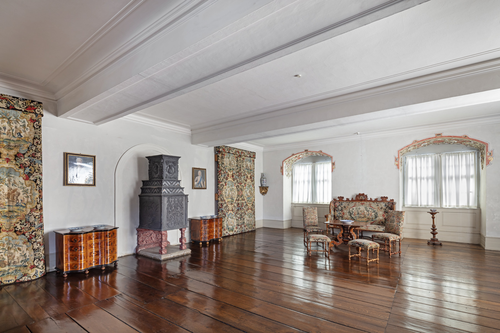

In [21]:
get_img("Q231")
#Bild Tafelstube

In [17]:
get_text("Q264")
#Programm und Synthese der einstigen Tafelstube

Wikibase link: [https://computational-publishing-service.wikibase.cloud/entity/Q264](https://computational-publishing-service.wikibase.cloud/entity/Q264)

Kurator: Seeger, Ulrike









Programm und Synthese der einstigen Tafelstube
----------------------------------------------



 Tafelstube und Saal hängen konzeptionell eng zusammen. Während der Saal mit der guten Herrschaft des Grafen Wolfgang einen regionalen Radius beschreibt, weitet sich in der Tafelstube der Horizont auf den Beitrag der Grafschaft Hohenlohe zur Rettung der Christenheit vor osmanischer Herrschaft. Räumlich verknüpft sind die beiden Bildprogramme durch das Relief des Innenportals mit der Belagerung von Gran (Eszergom) 1594 und die Deckenmalerei des Durchgangs, die mit der Beweinung des toten Adonis durch Venus und Amor auf den tragischen Tod des jüngsten Sohnes bei der Belagerung von Gran (Eszergom) 1604 vorausweist. Adonis als passionierter Jäger wiederum verband die Tafelstube mit dem Jagdzyklus an der Decke 

<hr>

In [18]:
#get_graph()
#Fehlermeldung enthält Zeichenkombinationen, die von LaTex nicht 
#verabeitet werden kann.